In [83]:
import numpy as np
import pandas as pd
import urllib
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import linregress
import gc, os, glob
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

import datetime

In [139]:
def concatliketerms(df):
    
    df.sort_values(by=['Protein A (gene name)', 'Protein B (gene name)'], inplace=True)    
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    oldSize = df.shape
    newSize = 0
    j = 1
    while oldSize != newSize:
        df.reset_index(inplace=True)
        df.drop('index', axis=1, inplace=True)
        df.sort_values(by=['Protein A (gene name)', 'Protein B (gene name)'], inplace=True) 
        # concattonate like terms and remove duplicates
        i = 1
        end = len(df.index)-1
        for index in df.index:
            if i % 100 == 0:
                print('\r', 'Loop '+ str(j)+': ' +str(i)+' Out of '+ str(len(df.index)), end=' ', flush=True)
            if index in df.index.values and index != end:
                if df.ix[index, 'Protein A (gene name)'] == df.ix[index+1, 'Protein A (gene name)']:
                    if df.ix[index, 'Protein B (gene name)'] == df.ix[index+1, 'Protein B (gene name)']:
                        df.ix[index, 'PubMed ID'] = str(df.ix[index, 'PubMed ID']) +'|'+str(df.ix[index+1, 'PubMed ID'])
                        df.ix[index, 'Source databases'] = df.ix[index, 'Source databases'] +'|'+df.ix[index+1, 'Source databases']
                        df.drop(index+1, axis=0, inplace=True)
                        
            i += 1
        j += 1
        oldSize = newSize
        newSize = df.shape

In [2]:
human_filtered = pd.read_csv('/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Filtered/ppi_network_human_filtered_2017_02_16.tsv', sep='\t')
mouse_filtered = pd.read_csv('/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Filtered/ppi_network_mouse_filtered_2017_02_15.tsv', sep='\t')

In [3]:
human_filtered.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,1B,DDX58,19193793,"psi-mi:""MI:0486""(UniProt)"
1,A1CF,APOBEC1,10669759|11134005|11134005|10669759,"psi-mi:""MI:0463""(biogrid)|psi-mi:""MI:0463""(bio..."
2,A1CF,CELF2,11577082,(mentha)
3,A1CF,KHSRP,10781591|10781591,"psi-mi:""MI:0463""(biogrid)|(mentha)"
4,A1CF,SYNCRIP,11134005|11134005|11352648,"psi-mi:""MI:0463""(biogrid)|(mentha)"


In [4]:
human_filtered.shape

(86995, 4)

In [5]:
lst = []
for pub in human_filtered['PubMed ID']:
#     lst.append(pub)
    p = []
    if 'M' in pub:
        b = pub.split('|')
        for n in b:
            if 'M' not in n:
                p.append(n)
        lst.append('|'.join(p))
                
    else:
        lst.append(pub)

human_filtered['PubMed ID'] = lst        

In [6]:
human_filtered.shape

(86995, 4)

In [7]:
lst = []
for pub in mouse_filtered['PubMed ID']:
#     lst.append(pub)
    p = []
    if 'M' in pub:
        b = pub.split('|')
        for n in b:
            if 'M' not in n:
                p.append(n)
        lst.append('|'.join(p))
                
    else:
        lst.append(pub)

mouse_filtered['PubMed ID'] = lst    

In [7]:
mouse_filtered.shape

(19866, 4)

In [9]:
mouse_filtered.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,1700006A11RIK,BMPR1B,15761153,(mentha)
1,1700021K19Rik,Becn1,19270693,MI:0974(innatedb)
2,1700021K19Rik,Cyba,22423966,MI:0974(innatedb)
3,1700021K19Rik,Cybb,22423966,MI:0974(innatedb)
4,A2NTY6,A2NTU7,17418792,(mentha)


In [8]:
#human[human['PubMed ID'].str.contains('MINT')].replace('MINT', '')

In [9]:
# #read in data from NCBI and write to file (only needs to be proformed once)
# content=urllib.request.urlopen('https://urldefense.proofpoint.com/v2/url?u=ftp-3A__ftp.ncbi.nih.gov_pub_HomoloGene_current_homologene.data&d=DwIGaQ&c=shNJtf5dKgNcPZ6Yh64b-A&r=FzzxHcpcdpeEl2SeS4RngXJfR5R4cEV8N2xULwaH8LE&m=H47AkOYhsWJidY3BTdZQzbIarlSka87imDJ8Qn9e6GY&s=YC09EJeihTYDzrM4EtbA25GGlFbj6g7PXooVz7WkyOk&e= ') 

# target = open('HomoloGene.tsv', 'wb')
# for line in content:
#     target.write(line)
# target.close()

In [10]:
col = ['HID (HomoloGene group id)', 'Taxonomy ID', 'Gene ID', 'Gene Symbol', 'Protein gi', 'Protein accession']

In [11]:
mapping = pd.read_csv('/Users/moshesilverstein/Desktop/PPI Library/Doc and Mapping/HomoloGene.tsv', sep='\t', names=col)

In [12]:
mapping.head()

,HID (HomoloGene group id),Taxonomy ID,Gene ID,Gene Symbol,Protein gi,Protein accession
0,3,9606,34,ACADM,4557231,NP_000007.1
1,3,9598,469356,ACADM,160961497,NP_001104286.1
2,3,9544,705168,ACADM,109008502,XP_001101274.1
3,3,9615,490207,ACADM,545503811,XP_005622188.1
4,3,9913,505968,ACADM,115497690,NP_001068703.1


In [13]:
human_mapping = mapping[mapping['Taxonomy ID'] == 9606]

In [14]:
#human_mapping.set_index('HID (HomoloGene group id)', inplace=True)

In [14]:
mouse_mapping = mapping[mapping['Taxonomy ID'] == 10090]

In [16]:
# mouse_mapping = mouse_mapping.reset_index().drop('index', axis=1)
# human_mapping = human_mapping.reset_index().drop('index', axis=1)

In [17]:
mouse_filtered[['Protein A (gene name)', 'Protein B (gene name)']]=mouse_filtered[['Protein A (gene name)', 'Protein B (gene name)']].applymap(lambda x: x.upper())

In [18]:
mouse_mapping['Gene Symbol']= mouse_mapping['Gene Symbol'].apply(lambda x: x.upper())

/Users/moshesilverstein/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.proofpoint.com/v2/url?u=http-3A__pandas.pydata.org_pandas-2Ddocs_stable_indexing.html-23indexing-2Dview-2Dversus-2Dcopy&d=DwIGaQ&c=shNJtf5dKgNcPZ6Yh64b-A&r=FzzxHcpcdpeEl2SeS4RngXJfR5R4cEV8N2xULwaH8LE&m=H47AkOYhsWJidY3BTdZQzbIarlSka87imDJ8Qn9e6GY&s=B1lTiq_WReCic5igFqQz2r8oLP4oU47aHZg8m5mLFFY&e= 
  if __name__ == '__main__':


In [17]:
#human_mapping['Gene Symbol']= human_mapping['Gene Symbol'].apply(lambda x: x.upper())

In [19]:
mouse_mapping = mouse_mapping[['HID (HomoloGene group id)','Gene Symbol']]
human_mapping = human_mapping[['HID (HomoloGene group id)','Gene Symbol']]
#human_mapping.set_index('HID (HomoloGene group id)', inplace=True)
#mouse_mapping.set_index('HID (HomoloGene group id)', inplace=True)

In [20]:
mouse_mapping.rename(columns={'Gene Symbol': 'GSM'}, inplace=True)

In [21]:
human_mapping.rename(columns={'Gene Symbol': 'GSH'}, inplace=True)

In [22]:
mouse_human = pd.merge(mouse_mapping, human_mapping, how='outer', on='HID (HomoloGene group id)')

In [23]:
mouse_mapping.head()

,HID (HomoloGene group id),GSM
5,3,ACADM
17,5,ACADVL
28,6,ACAT1
51,7,ACVR1
63,9,SGCA


In [24]:
human_mapping.head()

,HID (HomoloGene group id),GSH
0,3,ACADM
13,5,ACADVL
23,6,ACAT1
46,7,ACVR1
58,9,SGCA


In [25]:
mouse_human.head()

,HID (HomoloGene group id),GSM,GSH
0,3,ACADM,ACADM
1,5,ACADVL,ACADVL
2,6,ACAT1,ACAT1
3,7,ACVR1,ACVR1
4,9,SGCA,SGCA


In [26]:
lst = []
for name in mouse_human.GSM:
    name = str(name)
    lst.append(name.split(' ')[0])
mouse_human.GSM = lst

In [27]:
lst = []
for name in mouse_human.GSH:
    name = str(name)
    lst.append(name.split(' ')[0])
mouse_human.GSH = lst

In [28]:
i = 1
for index in mouse_filtered.index:
    print('\r', str(i)+' Out of '+ str(len(mouse_filtered.index)), end=' ', flush=True)
    if mouse_filtered.ix[index, 'Protein A (gene name)'] in mouse_human['GSM'].values:
        mouse_filtered.ix[index, 'Protein A (gene name)'] = mouse_human[mouse_human['GSM'] == mouse_filtered.ix[index, 'Protein A (gene name)']].GSH.values[0]
    else:
        mouse_filtered.ix[index, 'Protein A (gene name)'] = np.nan
    if mouse_filtered.ix[index, 'Protein B (gene name)'] in mouse_human['GSM'].values:
        mouse_filtered.ix[index, 'Protein B (gene name)'] = mouse_human[mouse_human['GSM'] == mouse_filtered.ix[index, 'Protein B (gene name)']].GSH.values[0]
    else:
        mouse_filtered.ix[index, 'Protein B (gene name)'] = np.nan

    
    i += 1

 19866 Out of 19866 

In [30]:
mouse_filtered.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,NaN,BMPR1B,15761153,(mentha)
1,KIAA0226,BECN1,19270693,MI:0974(innatedb)
2,KIAA0226,CYBA,22423966,MI:0974(innatedb)
3,KIAA0226,CYBB,22423966,MI:0974(innatedb)
4,NaN,NaN,17418792,(mentha)


In [31]:
mouse_filtered.dropna(inplace=True)

In [33]:
network_df = pd.concat([human_filtered, mouse_filtered])

In [34]:
network_df.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,1B,DDX58,19193793,"psi-mi:""MI:0486""(UniProt)"
1,A1CF,APOBEC1,10669759|11134005|11134005|10669759,"psi-mi:""MI:0463""(biogrid)|psi-mi:""MI:0463""(bio..."
2,A1CF,CELF2,11577082,(mentha)
3,A1CF,KHSRP,10781591|10781591,"psi-mi:""MI:0463""(biogrid)|(mentha)"
4,A1CF,SYNCRIP,11134005|11134005|11352648,"psi-mi:""MI:0463""(biogrid)|(mentha)"


In [35]:
network_df.shape

(106101, 4)

In [36]:
#network_df.pop('Unnamed: 0');

In [37]:
network_df.drop_duplicates(inplace=True)

In [38]:
network_df.shape

(105612, 4)

In [39]:
network_df.sort_values(['Protein A (gene name)', 'Protein B (gene name)'], inplace=True)

In [40]:
network_df.reset_index(inplace=True)
network_df.drop('index', axis=1, inplace=True)

In [42]:
concatliketerms(network_df)

 Loop 6: 95700 Out of 95758 

In [43]:
network_df.shape

(95758, 4)

In [44]:
network_df.dropna(inplace=True)

In [45]:
network_df.shape

(95758, 4)

In [46]:
network_df.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,1B,DDX58,19193793,"psi-mi:""MI:0486""(UniProt)"
1,A1CF,APOBEC1,10669759|11134005|11134005|10669759,"psi-mi:""MI:0463""(biogrid)|psi-mi:""MI:0463""(bio..."
2,A1CF,CELF2,11577082,(mentha)
3,A1CF,KHSRP,10781591|10781591,"psi-mi:""MI:0463""(biogrid)|(mentha)"
4,A1CF,SYNCRIP,11134005|11134005|11352648,"psi-mi:""MI:0463""(biogrid)|(mentha)"


In [49]:
filename = '/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Filtered/ppi_network_all_filtered_%s.tsv'% str(datetime.date.today()).replace('-', '_')
network_df.to_csv(filename, sep='\t', index=False) 

In [52]:
filename = '/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Filtered/ppi_network_all_filtered_%s.tsv.gz'% str(datetime.date.today()).replace('-', '_')
network_df.to_csv(filename, sep='\t', index=False, compression='gzip') 

In [102]:
human_uf_file = max(glob.glob('/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Unfiltered/ppi_network_human*.tsv'))
mouse_uf_file = max(glob.glob('/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Unfiltered/ppi_network_mouse*.tsv'))

In [103]:
human_unfiltered = pd.read_csv(human_uf_file, sep='\t')
mouse_unfiltered = pd.read_csv(mouse_uf_file, sep='\t')

In [104]:
human_unfiltered.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,1B,DDX58,19193793,"psi-mi:""MI:0486""(UniProt)"
1,1C,ACSL1,22593156,"psi-mi:""MI:0469""(IntAct)"
2,1C,ACSL3,22593156,"psi-mi:""MI:0469""(IntAct)"
3,1C,ACSL4,22593156,"psi-mi:""MI:0469""(IntAct)"
4,1C,AFG3L2,22593156,"psi-mi:""MI:0469""(IntAct)"


In [106]:
mouse_unfiltered.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,0610012G03RIK,PCBP1,11591653,(mentha)
1,1110037F02RIK,YWHAE,16615898,(mentha)
2,1600012H06RIK,YWHAE,16615898,(mentha)
3,1600012P17RIK,YWHAE,16615898,(mentha)
4,16AOH-B,YWHAE,16615898,(mentha)


In [110]:
i = 1
for index in mouse_unfiltered.index:
    print('\r', str(i)+' Out of '+ str(len(mouse_unfiltered.index)), end=' ', flush=True)
    if mouse_unfiltered.ix[index, 'Protein A (gene name)'] in mouse_human['GSM'].values:
        mouse_unfiltered.ix[index, 'Protein A (gene name)'] = mouse_human[mouse_human['GSM'] == mouse_unfiltered.ix[index, 'Protein A (gene name)']].GSH.values[0]
    else:
        mouse_unfiltered.ix[index, 'Protein A (gene name)'] = np.nan
    if mouse_unfiltered.ix[index, 'Protein B (gene name)'] in mouse_human['GSM'].values:
        mouse_unfiltered.ix[index, 'Protein B (gene name)'] = mouse_human[mouse_human['GSM'] == mouse_unfiltered.ix[index, 'Protein B (gene name)']].GSH.values[0]
    else:
        mouse_unfiltered.ix[index, 'Protein B (gene name)'] = np.nan

    
    i += 1

 61963 Out of 61963 

In [131]:
mouse_unfiltered.replace('nan', np.nan, inplace=True)

In [133]:
mouse_unfiltered.dropna(inplace=True)

In [136]:
mouse_unfiltered.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
1,KIAA1429,YWHAE,16615898,(mentha)
2,C6orf120,YWHAE,16615898,(mentha)
9,LOC102288414,YWHAE,16615898,(mentha)
10,KIAA1211L,YWHAE,16615898,(mentha)
18,FAM90A1,ATP6V1A,22707207,(mentha)


In [137]:
network_uf_df = pd.concat([human_unfiltered, mouse_unfiltered])

In [138]:
network_uf_df.head()

,Protein A (gene name),Protein B (gene name),PubMed ID,Source databases
0,1B,DDX58,19193793,"psi-mi:""MI:0486""(UniProt)"
1,1C,ACSL1,22593156,"psi-mi:""MI:0469""(IntAct)"
2,1C,ACSL3,22593156,"psi-mi:""MI:0469""(IntAct)"
3,1C,ACSL4,22593156,"psi-mi:""MI:0469""(IntAct)"
4,1C,AFG3L2,22593156,"psi-mi:""MI:0469""(IntAct)"


In [140]:
network_uf_df.shape

(475946, 4)

In [141]:
concatliketerms(network_uf_df)

 Loop 3: 470600 Out of 470684 

In [145]:
network_uf_df.shape

(470684, 4)

In [147]:
network_uf_df.dropna(inplace=True)

In [148]:
network_uf_df.shape

(470356, 4)

In [149]:
filename = '/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Unfiltered/ppi_network_all_unfiltered_%s.tsv'% str(datetime.date.today()).replace('-', '_')
network_uf_df.to_csv(filename, sep='\t', index=False) 

In [150]:
filename = '/Users/moshesilverstein/Desktop/PPI Library/Output/Combined/Unfiltered/ppi_network_all_unfiltered_%s.tsv.gz'% str(datetime.date.today()).replace('-', '_')
network_uf_df.to_csv(filename, sep='\t', index=False, compression='gzip') 

## Get Network Graph

In [122]:
genes = network_df['Protein A (gene name)'].values.tolist()+network_df['Protein B (gene name)'].values.tolist()
# genes = [item for sublist in genes for item in sublist]
genes = set(genes)
genes = list(genes)
genes.remove('nan')
genes.sort()
graph_df = pd.DataFrame(columns=genes, index=genes)

i = 1
for index in network_df.index:
    if i % 100 == 0:
        print('\r', str(i)+' Out of '+ str(len(network_df.index)), end=' ', flush=True)
    graph_df.ix[network_df.ix[index, 'Protein A (gene name)'], network_df.ix[index, 'Protein B (gene name)']] = 1
    graph_df.ix[network_df.ix[index, 'Protein B (gene name)'], network_df.ix[index, 'Protein A (gene name)']] = 1
    i += 1

graph_df.replace(np.nan, 0, inplace=True)

 88000 Out of 88006 

In [128]:
graph_df.pop('nan')
graph_df.T.pop('nan')

In [86]:
graph_df.ix['A1CF', 'CELF2']

1

In [129]:
graph_df.T.head()

,1B,A0A024R2Q0,A0A0C4DGW0,A1BG,A1CF,A2M,AAAS,AAGAB,AAK1,AAMP,...,ZSWIM7,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZZ3,dystrophin,p72syk
1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A024R2Q0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0C4DGW0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2D Graph

In [98]:
def show_graph(adjacency_matrix):
    # given an adjacency matrix use networkx and matlpotlib to plot the graph
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    # nx.draw(gr) # edited to include labels
    nx.draw_networkx(gr, with_labels=False)
    # now if you decide you don't want labels because your graph
    # is too busy just do: nx.draw_networkx(G,with_labels=False)
    plt.show() 

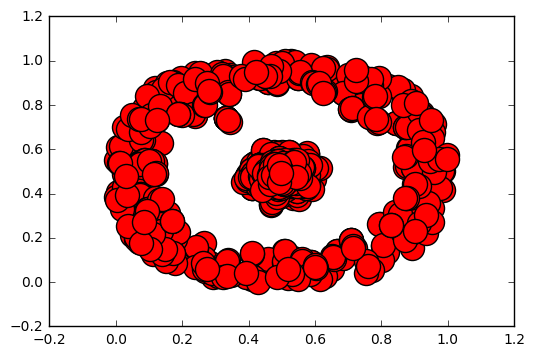

In [99]:
show_graph(np.matrix(graph_df.values))

In [130]:
n = []
i = 1
for index in graph_df.index:
    print('\r', str(i)+' Out of '+ str(len(graph_df.index)), end=' ', flush=True)
    n.append(graph_df.ix[index].sum())
    i += 1
number_of_links = pd.DataFrame(index=genes, data=n)

 10454 Out of 10454 

In [131]:
number_of_links.head()

,0
1B,1
A0A024R2Q0,1
A0A0C4DGW0,1
A1BG,1
A1CF,5


In [132]:
number_of_links[number_of_links.values >= 50]

,0
ABL1,167
ACTA1,71
ACTB,127
AGO2,60
AKT1,256
AMFR,54
APC,89
APP,151
AR,263
ARRB1,88


In [295]:
hub_loc = pd.DataFrame(index=number_of_links[number_of_links.values >= 50].index[0:50], columns=['x','y','z'])

sample_per_side = np.round(np.power(len(hub_loc.index), (1./3)))

dist = 10

x_list = (np.arange(0, dist*sample_per_side, dist).tolist()*(np.round(len(hub_loc.index)/int(sample_per_side))+sample_per_side))[0:len(hub_loc.index)]
z_list = (np.arange(0, dist*sample_per_side, dist).tolist()*(np.round(len(hub_loc.index)/int(sample_per_side))+sample_per_side))[0:len(hub_loc.index)]
y_list = []
list_y = (np.arange(0, dist*sample_per_side, dist).tolist())
for n in list_y:
    y_list.append([n]*sample_per_side)
y_list = [y_list]*sample_per_side

y_list = [item for sublist in y_list for item in sublist]
y_list = [item for sublist in y_list for item in sublist]
y_list = y_list[0:len(hub_loc.index)]
          
          
hub_loc['x'] = np.sort(x_list)
hub_loc['y'] = y_list
hub_loc['z'] = z_list
                
hub_loc.head()

/Users/moshesilverstein/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/moshesilverstein/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/moshesilverstein/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/moshesilverstein/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,x,y,z
ABL1,0.0,0.0,0.0
ACTA1,0.0,0.0,10.0
ACTB,0.0,0.0,20.0
AGO2,0.0,0.0,30.0
AKT1,0.0,10.0,0.0


In [296]:
len(x_list)
len(hub_loc.index)
np.round(len(hub_loc.index)/int(sample_per_side))
sample_per_side

4.0

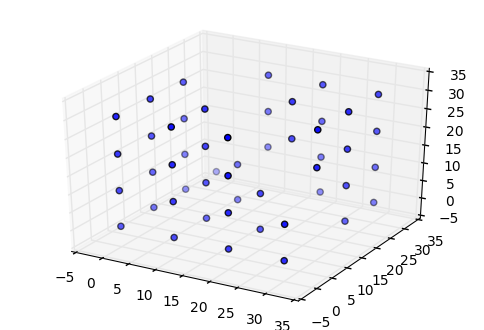

In [297]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hub_loc['x'], hub_loc['y'], hub_loc['z'])

In [287]:
def distance(a,b):
    c = np.array(a)-np.array(b)
    return np.linalg.norm(c)

In [298]:
link_dist = 5
for index1 in hub_loc.index:
    for index2 in hub_loc.index:
        if index1 != index2:
            pos1 = [hub_loc.ix[index1, 'x'], hub_loc.ix[index1, 'y'], hub_loc.ix[index1, 'z']]
            pos2 = [hub_loc.ix[index2, 'x'], hub_loc.ix[index2, 'y'], hub_loc.ix[index2, 'z']]
            dist = distance(pos1, pos2)
            if graph_df.ix[index1, index2] == 1:
                if dist > link_dist:
                    hub_loc.ix[index2, 'x'] = pos1[0] - pow((pow(link_dist, 2)-pow((pos1[1]-pos2[1]), 2)-pow((pos1[2]-pos2[2]), 2)), (1/2))

/Users/moshesilverstein/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


In [299]:
hub_loc.head(50)

,x,y,z
ABL1,0.0,0.0,0.0
ACTA1,NaN,0.0,10.0
ACTB,0.0,0.0,20.0
AGO2,0.0,0.0,30.0
AKT1,NaN,10.0,0.0
AMFR,0.0,10.0,10.0
APC,0.0,10.0,20.0
APP,NaN,10.0,30.0
AR,NaN,20.0,0.0
ARRB1,0.0,20.0,10.0


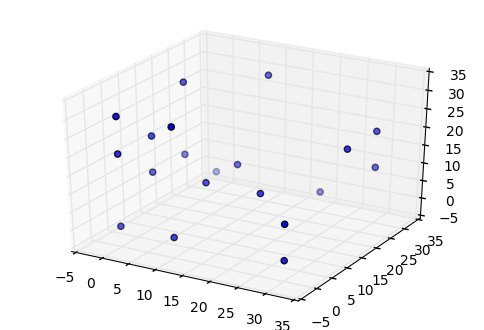

In [290]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hub_loc['x'], hub_loc['y'], hub_loc['z'])

In [228]:
#(np.arange(0, sample_per_side).tolist()*np.round(len(hub_loc.index)/sample_per_side))[0:len(hub_loc.index)].sort()
#len(hub_loc.index)/sample_per_side
#y_list

## Get Network Stats

In [45]:
lst = []
for pub in network_df['PubMed ID'].values.tolist():
    lst.append(pub.split('|'))
#lst = lst.flatten()
lst = 
lst = set(lst)
print('The number of unique PubMed IDs is ' + str(len(lst)))

The number of unique PubMed IDs is 34165


In [46]:
lst = []
lst.append(network_df['Protein A (gene name)'].values.tolist()+network_df['Protein B (gene name)'].values.tolist())
lst = [item for sublist in lst for item in sublist]
lst = set(lst)
print('The number of unique Nodes is ' + str(len(lst)))

The number of unique Nodes is 10455


In [47]:
print('The number of unique links is ' + str(network_df.shape[0]))

The number of unique links is 88006


## Plot Network Data (Histogram/LOGLOG)

In [48]:
lst1 = []
lst1.append(network_df['Protein A (gene name)'].values.tolist()+network_df['Protein B (gene name)'].values.tolist())
lst1 = [item for sublist in lst1 for item in sublist]
lst1 = set(lst1)
lst1 = list(lst1)
#lst1
lst2 = []
i = 1
for name in lst1:
    if i % 100 == 0:
        print('\r', str(i)+' Out of '+ str(len(lst1)), end=' ', flush=True)
    lst2.append((network_df == name).sum()[0]+(network_df == name).sum()[1])
    i += 1
#lst2

 10400 Out of 10455 

In [49]:
len(lst1)

10455

In [50]:
#dist['number of links'].max()
#dist['number of links'].mean()

<https://urldefense.proofpoint.com/v2/url?u=http-3A__matplotlib.collections.PathCollectionat0x117064fd0&d=DwIGaQ&c=shNJtf5dKgNcPZ6Yh64b-A&r=FzzxHcpcdpeEl2SeS4RngXJfR5R4cEV8N2xULwaH8LE&m=H47AkOYhsWJidY3BTdZQzbIarlSka87imDJ8Qn9e6GY&s=0xYkuVYHboFnRiOg1LgPq51bi2GNeUGoUhysxJgzXr4&e= >

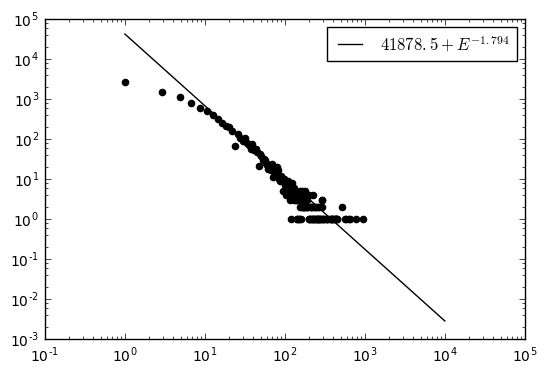

In [51]:
gc.collect()
d = {'genes':lst1, 'number of links':lst2}
dist = pd.DataFrame(d)

fig = plt.figure()

# axes1 = fig.add_axes([-0.3, 0.1, 0.8, 0.8])
# axes2 = fig.add_axes([0.6, 0.1, 0.8, 0.8])
axes3 = fig.add_axes([-0.3, -0.9, 0.8, 0.8])

# # main figure
# dist['number of links'].hist(bins=100, normed=True, ax=axes1, linestyle='dashed',color='black')
# # axes1.set_xlabel('x')
# # axes1.set_ylabel('y')
# axes1.set_title('total distribution');

# # insert
# dist['number of links'].hist(bins=500, normed=True, ax=axes2, linestyle='dashed', color='black')
# axes2.set_xlim(0,100);
# # axes2.set_xlabel('y')
# # axes2.set_ylabel('x')
# axes2.set_title('zoomed in');
# #fig.tight_layout()


axes3.set_yscale('log');
axes3.set_xscale('log');
count, division = np.histogram(dist['number of links'], bins=500);

bincenters = 0.5*(division[1:]+division[:-1]);
fit = np.polyfit(bincenters[0:500],count,0);
fit_fn = np.poly1d(fit);
#axes3.plot(division[0:500], fit_fn(division[0:500]))
#axes3.scatter(division[0:500], count)
newX = np.logspace(0, 4, base=10);
def myExpFunc(x, a, b):
    return a * np.power(x, b)
popt, pcov = curve_fit(myExpFunc, bincenters[5:100], count[5:100]);
tag = r"$%.1f+E^{%.3f}$" % (popt[0], popt[1])
#str(int(popt[0]))+'*x**'+str(popt[1])
#f"{numvar:.9f}"
axes3.plot(newX, myExpFunc(newX, *popt), 'k-', label=tag)
#axes3.set_title('LogLog Plot');
axes3.legend(loc=1);
count = count.astype(float)
count[count==0] = np.nan
axes3.scatter(division[0:500], count[0:500], c='black')

# dist['number of links'].hist(bins=500, ax=axes4, linestyle='dashed', color='black')
# axes4.set_xscale('log');
# axes4.set_yscale('log');
# axes4.set_xlim(1,100);
# # slope, intercept, r_value, p_value, std_err = linregress(np.log10(division[0:3]), np.log10(count[0:3]))
# # axes4.plot(division[0:3], division[0:3]*slope+intercept)
# popt, pcov = curve_fit(myExpFunc, bincenters[5:100], count[5:100]);
# tag = str(int(popt[0]))+'*x**'+str(popt[1])
# axes4.plot(newX, myExpFunc(newX, *popt), 'k-', label=tag)
# axes4.set_title('LogLog Plot Zoomed In');
# axes4.legend(loc=1);

In [52]:
#count[count == 0] = 1

In [53]:
#count

### Build Gene Set Library

In [56]:
df = pd.concat([human, mouse])

In [57]:
df = df[['Protein A (gene name)', 'Protein B (gene name)']]

In [58]:
df.drop_duplicates(inplace=True)

In [59]:
df.dropna(inplace=True)

In [60]:
# build library

i = 1

genelist = set(df['Protein A (gene name)'].values.tolist() + df['Protein B (gene name)'].values.tolist())

lib = pd.DataFrame()

for gene in genelist:
    if i % 100 == 0:
        print('\r', str(i)+' Out of '+ str(len(genelist)), end=' ', flush=True)
    lst = set(df[df.values == gene].values.flatten().tolist())
    lst.remove(gene)
    lst = list(lst)
    lst.insert(0, gene)
    if len(lst) >= 50:
        temp = pd.DataFrame(data=lst)
        lib = pd.concat([lib, temp.T])
    i += 1

 10500 Out of 10557 

In [61]:
lib.head(20)

,0,1,2,3,4,5,6,7,8,9,...,589,590,591,592,593,594,595,596,597,598
0,TUBA1A,CYLD,ESR1,MDK,DNM1,YWHAQ,GZMB,SAV1,PPID,VHL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,FOXO1,ESR1,PDGFRA,SIRT2,PRKACA,FOXP3,AKT1,CCNB1,IL7R,AR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ILK,ACACA,ITGB1,PRKDC,DPM1,PIP3,PXN,AKT1,SDF4,MTOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,SHC1,ITGB1,NTRK3,VAV3,SH2B2,EPHA2,JAK2,SHCBP1,AP2A1,FYN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NFKBIA,UFD1L,CSNK2B,ARRB2,CASP3,UBA2,TLR2,ABL1,BTRC,HOXD1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,JAK1,PTPN2,SHB,IFNGR1,IL6ST,RNF125,HIST3H3,CABYR,IL5RA,TSHR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,TRAF1,TNFRSF18,TMC8,SRC,CASP2,MAP3K14,CASP10,CD40,TANK,TNFRSF8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PXN,CRK,ITGB1,PKLR,TRIP6,PTPN12,LIMK2,SRC,DNM1,RET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,RBBP4,GATAD2B,ESR1,CDK2AP1,HIC1,HIST1H3A,HDAC1,HIST1H4A,ING1,MBD2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PRKDC,HSF1,LMNA,NR1H4,AKT1,RPA1,ILF2,PCNA,CASP3,ABL1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
lib.shape

(442, 599)

In [65]:
filename = '/Users/moshesilverstein/Desktop/PPI Library/Output/gene_set_library_%s.gmt'% str(datetime.date.today()).replace('-', '_')
lib.to_csv(filename, sep='\t', index=False) 

In [66]:
filename = '/Users/moshesilverstein/Desktop/PPI Library/Output/gene_set_library_%s.gmt.gz'% str(datetime.date.today()).replace('-', '_')
lib.to_csv(filename, sep='\t', index=False, compression='gzip') 

In [62]:
lib.T.describe()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
count,121,88,143,53,133,110,94,87,63,52,...,61,123,113,71,110,63,122,83,66,73
unique,121,88,143,53,133,110,94,87,63,52,...,61,123,113,71,110,63,122,83,66,73
top,SAE1,TSC2,PRKDC,PSEN2,RNF122,CASP10,BMX,BCL3,BAG6,MSN,...,BTRC,GLI3,ASXL1,KLF10,MLANA,IL1B,MCM10,KATNA1,TSC2,PDGFRB
freq,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [63]:
#genelist